In [1]:
%matplotlib inline
from edgenerator import make_graph
from biom import load_table
from jinja2 import Environment
from json import dumps
from skbio import DistanceMatrix

import pandas as pd
import numpy as np
import networkx as nx

In [2]:
def load_mf(fn):
    _df = pd.read_csv(fn, sep='\t', dtype=str, keep_default_na=False, na_values=[])
    _df.set_index('#SampleID', inplace=True)
    return _df

In [44]:
!scp barnacle:filtered.emp-90-gg-1k-unweighted_unifrac.txt .

/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH
filtered.emp-90-gg-1k-unweighted_unifrac.txt  100%  355MB  16.2MB/s   00:22    


In [45]:
!scp barnacle:/projects/emp/00-qiime-maps/merged/emp_qiime_mapping_all_emp.tsv .

/home/yovazquezbaeza/.bashrc: line 34: module: command not found
discarding /home/yovazquezbaeza/miniconda/bin from PATH
prepending /home/yovazquezbaeza/miniconda/envs/qiime/bin to PATH
emp_qiime_mapping_all_emp.tsv                 100%   18MB  18.2MB/s   00:01    


In [3]:
mf = load_mf('emp_qiime_mapping_all_emp.tsv')
dm = DistanceMatrix.read('filtered.emp-90-gg-1k-unweighted_unifrac.txt')

In [4]:
mf = mf.loc[list(dm.ids)].copy()

In [5]:
mf['latitude_deg'] = pd.to_numeric(mf['latitude_deg'], errors='coerce')
mf['longitude_deg'] = pd.to_numeric(mf['longitude_deg'], errors='coerce')

In [6]:
# add some noise :L
mf['latitude_deg'] = mf['latitude_deg'] + np.random.normal(size=len(mf))
mf['longitude_deg'] = mf['longitude_deg'] + np.random.normal(size=len(mf))

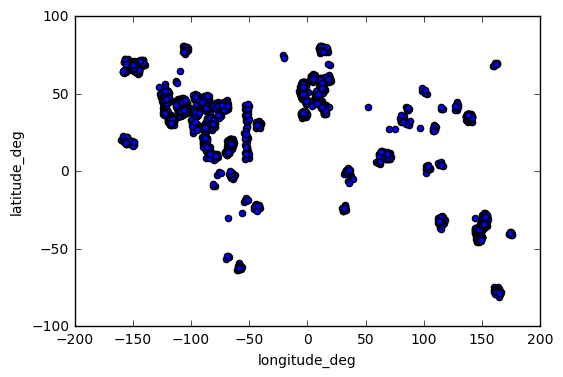

In [7]:
mf.plot('longitude_deg', 'latitude_deg', kind='scatter')

Create the graphs to compute the minimum graph.

In [10]:
g = nx.from_numpy_matrix(dm.data)
g = nx.relabel_nodes(g, dict(zip(g.nodes(), dm.ids)))

In [11]:
nx.write_gpickle(g, 'graph-filtered.emp-90-gg-1k-unweighted_unifrac.pickle')

In [6]:
g = nx.read_gpickle('graph-filtered.emp-90-gg-1k-unweighted_unifrac.pickle')

In [8]:
with open('minimum-edge-list.txt', 'w') as f:
    for u, v, d in min_edges:
        f.write('%s\t%s\t%f\n' % (u, v, d))

In [ ]:
min_edges = []
i = 0
for n in g.nodes():
    min_w = np.inf
    min_u_v = None
    
    for u, v, data in g.edges(n, data=True):
        
        if data['weight'] <= min_w:
            min_w = data['weight']
            min_u_v = (u, v, min_w)
    min_edges.append(min_u_v)

If you don't want to compute the minimum graph everytime, you can load this list.

In [8]:
min_edges = pd.read_csv('minimum-edge-list.txt', sep='\t', header=None).as_matrix().tolist()

In [9]:
f = nx.Graph()
for u, v, d in min_edges:
    f.add_edge(u, v, attr_dict={'weight': d})

In [10]:
# get only these two columns as a dict, retrieving
# only samples present in the graph
attribs = mf[['latitude_deg', 'longitude_deg', 'empo_3', 'title']].loc[f.nodes()].to_dict()

nx.set_node_attributes(f, 'latitude_deg', attribs['latitude_deg'])
nx.set_node_attributes(f, 'longitude_deg', attribs['longitude_deg'])
nx.set_node_attributes(f, 'empo_3', attribs['empo_3'])

In [11]:
empo_cat_color={'EMP sample': 'white',
                'Host-associated': '#fb9a99',
                'Free-living': '#e31a1c',
                'Animal': '#b2df8a',
                'Plant': '#33a02c',
                'Non-saline': '#a6cee3',
                'Saline': '#1f78b4',
                'Aerosol (non-saline)': 'lightgrey',
                'Animal corpus': 'yellow',
                'Animal distal gut': 'saddlebrown',
                'Animal proximal gut': 'tan',
                'Animal secretion': 'sandybrown',
                'Animal surface': 'DarkGoldenRod',
                'Hypersaline (saline)': 'lightskyblue',
                'Intertidal (saline)': 'PaleTurquoise',
                'Mock community': 'fuchsia',
                'Plant corpus': 'lawngreen',
                'Plant rhizosphere': 'darkgreen',
                'Plant surface': 'MediumSpringGreen',
                'Sediment (non-saline)': 'lightsalmon',
                'Sediment (saline)': 'tomato',
                'Soil (non-saline)': 'red',
                'Sterile water blank': 'violet',
                'Surface (non-saline)': 'black',
                'Surface (saline)': 'dimgrey',
                'Water (non-saline)': 'navy',
                'Water (saline)': 'royalblue'}

In [12]:
edges = []

for edge in f.edges_iter():
    u, v = edge
    
    if attribs['empo_3'][u] != attribs['empo_3'][v]:
        color = 'white'
    else:
        color = empo_cat_color[attribs['empo_3'][u]]

    edges.append({'origin': {'latitude': attribs['latitude_deg'][u],
                             'longitude':attribs['longitude_deg'][u],
                             'empo_3': attribs['empo_3'][u]
                            },
                  'destination': {'latitude': attribs['latitude_deg'][v],
                                  'longitude': attribs['longitude_deg'][v],
                                  'empo_3': attribs['empo_3'][v]
                                 },
                  'strokeColor': color
                 })

In [44]:
countries = mf.country.apply(lambda x: x[4:])\
                      .replace({'United States of America': 'United States'})\
                      .value_counts()\
                      .to_dict()

In [59]:
with open('zoom-template.html', 'r') as fd:
    template = Environment().from_string(fd.read())

with open('generated-mingraph-zoomable-colors.html', 'w') as fd:
    fd.write(template.render(edge_data=dumps(edges), countries=dumps(countries)))

In [69]:
# https://github.com/markmarkoh/datamaps/issues/222

In [ ]:
Filter the mapping file to include some useful information, 

In [40]:
countries = mf.country.apply(lambda x: x[4:]).replace({'United States of America': 'United States'}).value_counts().to_dict()

In [41]:
countries

{'Antarctica': 69,
 'Arctic Ocean': 58,
 'Argentina': 6,
 'Australia': 396,
 'Belize': 18,
 'Brazil': 28,
 'Canada': 37,
 'China': 39,
 'Costa Rica': 21,
 'Curacao Island': 35,
 'Ecuador': 3,
 'England': 81,
 'English Channel': 58,
 'France': 4,
 'French Polynesia': 16,
 'Germany': 82,
 'Greenland': 3,
 'Gulf of Mexico': 80,
 'India': 2,
 'Italy': 110,
 'Japan': 198,
 'Kenya': 18,
 'Malaysia': 18,
 'Mexico': 19,
 'Mongolia': 11,
 'New Zealand': 9,
 'Nicaragua': 9,
 'North Atlantic Ocean': 102,
 'Norway': 136,
 'Pacific Ocean': 3,
 'Panama': 30,
 'Puerto Rico': 356,
 'Russia': 6,
 'Scotland': 57,
 'Singapore': 8,
 'South Africa': 22,
 'Spain': 76,
 'Sweden': 92,
 'Tanzania': 5,
 'United Kingdom': 2,
 'United States': 2523,
 'Venezuela': 154}